In [79]:
import math
import numpy as np
import pandas as pd
import scipy as sp
import numpy.random as npr  
import scipy.stats as scs
import matplotlib.pyplot as plt
import numpy.random as npr
import datetime
from scipy import optimize
#plt.style.use('seaborn')  # sets the plotting style

In [80]:
# SVCJ parameters
mu      = 0.042
r       = mu
mu_y    = -0.0492
sigma_y = 2.061
l       = 0.0515
alpha   = 0.0102
beta    = -0.188
rho     = 0.275
sigma_v = 0.007
rho_j   = -0.210
mu_v    = 0.709
v0      = 0.19**2 
kappa   = 1-beta
theta   = alpha / kappa

In [81]:
npr.seed(12345)
dt      = 1/360.0 # dt
m       = int(360.0 * (1/dt)/360.0) # time horizon in days
n       = 1000000

#trialrun
#dt     = 1/10
#n      = 1000
#m      = int(10*(1/dt)/10)

In [82]:
T      = m * dt
t      = np.arange(0,T+dt, dt)

In [83]:
w      = npr.standard_normal([n,m])
w2     = rho * w + sp.sqrt(1-rho**2) * npr.standard_normal([n,m])
z_v    = npr.exponential(mu_v, [n,m])
z_y    = npr.standard_normal([n,m]) * sigma_y + mu_y + rho_j * z_v
dj     = npr.binomial(1, l * dt, size=[n,m])
s      = np.zeros([n,m+1])
v      = np.zeros([n,m+1])

In [84]:
s0     = 6500
k      = 5600
s[:,0] = s0 # initial CRIX level, p. 20
v[:,0] = v0

In [85]:
for i in range(1,m+1):
    v[:,i] = v[:,i-1] + kappa * (theta - np.maximum(0,v[:,i-1])) * dt + sigma_v * sp.sqrt(np.maximum(0,v[:,i-1])) * w2[:,i-1] + z_v[:,i-1] * dj[:,i-1]
    s[:,i] = s[:,i-1] * (1 + (r - l * (mu_y + rho_j * mu_v)) * dt + sp.sqrt(v[:,i-1] * dt) * w[:,i-1]) + z_v[:,i-1] * dj[:,i-1]


C:\Users\maticjov\.conda\envs\lilisplace\lib\site-packages\ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


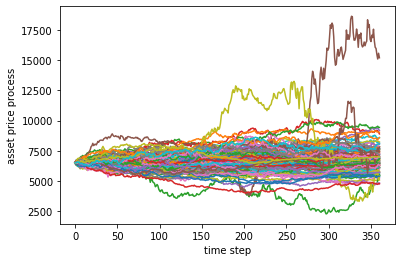

In [86]:
plt.plot(np.transpose(s[:100]));
plt.xlabel('time step')
plt.ylabel('asset price process')
plt.savefig('svcjassetpath.png',transparent=T)

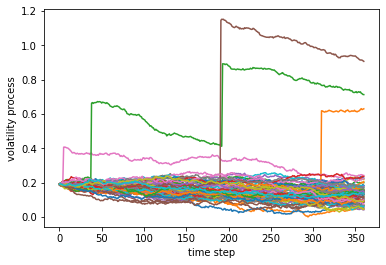

In [87]:
plt.plot(np.transpose(sp.sqrt(v[:70])));
plt.xlabel('time step')
plt.ylabel('volatility process')
plt.savefig('volpath.png',transparent=T)

In [88]:
# Option pricing 
cp    = np.exp(-mu * m * dt) * np.maximum(s[:,-1]-k,0).mean()
cp

1261.9166993956092

For the price process to be a martingale (=risk-neutral), this should be approximately $S_0$ (6500).

In [89]:
np.exp(-mu * m *dt) * s[:,-1].mean()

6564.792472206772

Implied volatility

In [90]:
def callprice(S,K,T,sigma,r):
    d1=(sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    d2=(sp.log(S/K) + (r - 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    return S*scs.norm.cdf(d1) - sp.exp(-r *T) * K * scs.norm.cdf(d2)

#callprice(100,100,1,0.2,0.05)

In [91]:
#Implied volatility for given strike

def solve(sigma, cp, k, T):
    return (callprice(100, k, T, sigma, r) - cp)**2

result = sp.optimize.minimize(solve, 0.2, args=(cp, k, T))
#result.x[0]
#callprice(s0, k, T, result.x[0], mu)

Normalise everything to $S_0=100$

In [92]:
s2 = s
s  = s2/s0 * 100


In [93]:
def call_and_vol(K, T): # T maturity in years
    m  = int(np.round(T / dt))
    cp = np.exp(-r * m * dt) * np.maximum(s[:,-1]-K,0).mean()
    iv = sp.optimize.minimize(solve, 0.4, args=(cp, K,T)).x[0]
    return [cp, iv]

#[call_and_vol(120,0.5), callprice(100, 120, 0.5, 0.98, r)]
#call_and_vol(120,0.5)

From here on we do everything on $S_0=100$

In [94]:
strike      = np.arange(.7, 1.3, 0.1)*100
ttm         = np.arange(30, 360, 30)/360
print(len(strike))
strike, ttm = np.meshgrid(strike, ttm)
#strike.shape

7


In [95]:
path =  'option_data.h5'

h5   = pd.HDFStore(path, 'r')
data = h5['data']  # European call & put option data (3 maturities)
#h5.close()
#type(data)
#data.info()
#data.head()

In [102]:
iv   = np.zeros(strike.shape)
call = np.zeros(strike.shape)
df   = pd.DataFrame(columns=data.columns)
i    = 0
date = datetime.date(2019, 7, 4)
for k in range(strike.shape[1]):
    for t in range(strike.shape[0]):
        [x, y]    = call_and_vol(strike[t,k], ttm[t,k])
        iv[t,k]   = y
        call[t,k] = x
        df.loc[i] = [date, strike[t,k], x, date + datetime.timedelta(days=ttm[t,k]*365), 0]
        i        += 1

In [ ]:
df2 = df[(df['Strike'] > 90.0) & (df['Strike'] < 105.0)] ## restrict to ATM options

In [ ]:
df.to_csv('callprices.csv', index=False)

In [ ]:
#compute Black-Scholes calibrated parameter
def solve_bs(sigma):
    return (callprice(100, df['Strike'], ttm.reshape(77), sigma, r) - df['Call'])**2

from scipy.optimize import root
impliedvol = optimize.root(solve_bs,0.2, method='lm').x
impliedvol

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  
fig = plt.figure(figsize=(12, 7)) 
ax = fig.gca(projection='3d')   # set up canvas for 3D plotting
surf = ax.plot_surface(strike/100, ttm, iv, rstride=3, cstride=3,
                       cmap=plt.cm.coolwarm, linewidth=0.5,
                       antialiased=True)  # creates 3D plot
ax.view_init(30, 30)
ax.set_xlabel('moneyness')  
ax.set_ylabel('time-to-maturity')  
ax.set_zlabel('implied volatility')  
fig.colorbar(surf, shrink=0.5, aspect=5);
plt.savefig('Pics/SVCJ_volsurface.png',transparent=T)